# Chapter 2. Text Classification

## Setup

In [1]:
# !pip install matplotlib


In [2]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification,  Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f'device: {device}')

emotions = load_dataset("emotion")
emotions


device: cuda


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_ds = emotions["train"]
test_ds = emotions["test"]
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [4]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
df['label_name'] = df['label'].apply(lambda x: train_ds.features['label'].int2str(x))
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Looking at the Class Distribution

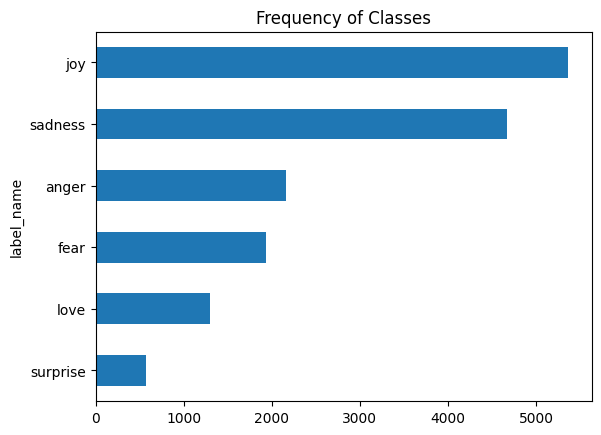

In [6]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

  * Randomly oversample the minority class.

  * Randomly undersample the majority class.

  * Gather more labeled data from the underrepresented classes.

To keep things simple in this chapter, we’ll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the Imbalanced-learn library. Just make sure that you don’t apply sampling methods _before_ creating your train/test splits, or you’ll get plenty of leakage between them!

Now that we’ve looked at the classes, let’s take a look at the tweets themselves.

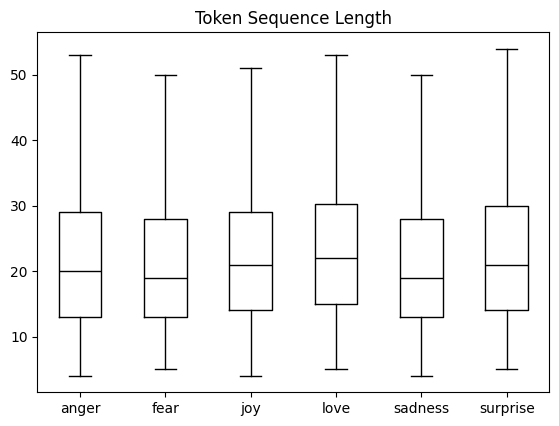

In [7]:
MODEL_ID = "answerdotai/ModernBERT-base"
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# find length of tokenized text. use the hf tokenizer
df["Token Sequence Length"] = df["text"].apply(lambda x: len(tokenizer.encode(x)))


df.boxplot("Token Sequence Length", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [8]:
emotions.reset_format()

## Tokenization

In [9]:
print(f'tokenizer vocab size: {tokenizer.vocab_size}')
# print(f'tokenizer model max length: {tokenizer.model_max_length}') # this is ridiculous. grab the max input size from model.config.max_position_embeddings
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=emotions['train'].features['label'].num_classes)
model_max_input_size = model.config.max_position_embeddings
print(f'model max input size: {model_max_input_size}')

tokenizer vocab size: 50280


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model max input size: 8192


In [10]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=model_max_input_size)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training

In [11]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [12]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{MODEL_ID}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=6,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/training_args.py:1573: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_12237/1626755990.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.825800,0.321412,0.889500,0.891482
2,0.193100,0.175749,0.924500,0.923321
3,0.102200,0.161346,0.931500,0.932219
4,0.058600,0.190300,0.930500,0.930105
5,0.028500,0.215995,0.928000,0.928241
6,0.014100,0.231761,0.933000,0.932973
